## 문제 1

### 문제1. _01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
import sys
from pathlib import Path

# 경로를 BACKEND_AI에 맞춰 수정
BASE_PATH = str(Path().resolve().parent.parent.parent)
CURRENT_FILE_PATH = str(Path().resolve())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 데이터 파일을 따로 가져와서 사용했기에 import 수정
from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset

# 주어진 값으로 수정
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
 
  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config={
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model, log="all", log_freq=100)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  # BackEnd AI에서 sys.argv = ['']를 넣어주지 않으면 오류가 발생함을 확인
  sys.argv = [''] 
  parser = get_parser()
  args = parser.parse_args()
  main(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: duehee (duehee-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 9.85825, V_loss: 75.04828, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 6.30646, V_loss: 46.05244, V_loss decreased (75.04828 --> 46.05244). Saving model... | T_time: 00:00:01, T_speed: 0.044
[Epoch  60] T_loss: 0.78971, V_loss: 12.70763, V_loss decreased (46.05244 --> 12.70763). Saving model... | T_time: 00:00:03, T_speed: 0.194
[Epoch  90] T_loss: 0.34244, V_loss: 6.33189, V_loss decreased (12.70763 --> 6.33189). Saving model... | T_time: 00:00:04, T_speed: 0.110
[Epoch 120] T_loss: 0.21268, V_loss: 3.66562, V_loss decreased (6.33189 --> 3.66562). Saving model... | T_time: 00:

[Epoch 1830] T_loss: 0.01289, V_loss: 0.17896, Early stopping counter: 6 out of 30 | T_time: 00:01:31, T_speed: 9.214
[Epoch 1860] T_loss: 0.01283, V_loss: 0.17715, Early stopping counter: 7 out of 30 | T_time: 00:01:32, T_speed: 3.523
[Epoch 1890] T_loss: 0.01265, V_loss: 0.16471, V_loss decreased (0.16606 --> 0.16471). Saving model... | T_time: 00:01:34, T_speed: 50.095
[Epoch 1920] T_loss: 0.01268, V_loss: 0.17644, Early stopping counter: 1 out of 30 | T_time: 00:01:35, T_speed: 4.912
[Epoch 1950] T_loss: 0.01243, V_loss: 0.18650, Early stopping counter: 2 out of 30 | T_time: 00:01:36, T_speed: 2.662
[Epoch 1980] T_loss: 0.01221, V_loss: 0.18026, Early stopping counter: 3 out of 30 | T_time: 00:01:38, T_speed: 37.424
[Epoch 2010] T_loss: 0.01244, V_loss: 0.18048, Early stopping counter: 4 out of 30 | T_time: 00:01:39, T_speed: 5.086
[Epoch 2040] T_loss: 0.01186, V_loss: 0.17592, Early stopping counter: 5 out of 30 | T_time: 00:01:40, T_speed: 2.249
[Epoch 2070] T_loss: 0.01236, V_lo

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▅▁▄▁▂▁▁▁▂▂▁▂█
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2790
Training loss,0.0092
Training speed (epochs/sec.),132.39062
Validation loss,0.21716


### 문제1, _01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

MODEL FILE: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 989.00 <--> 1,272.01 (Loss:        283.01)
 1: 1,002.14 <--> 1,334.58 (Loss:        332.44)
 2: 932.54 <--> 1,059.85 (Loss:        127.32)
 3: 1,002.21 <--> 1,360.09 (Loss:        357.88)
 4: 999.03 <--> 1,380.87 (Loss:        381.84)
 5: 998.21 <--> 1,319.45 (Loss:        321.24)
 6: 991.56 <--> 1,271.21 (Loss:        279.66)
 7: 1,001.67 <--> 1,378.05 (Loss:        376.38)
 8: 933.51 <--> 1,047.88 (Loss:        114.37)
 9: 990.17 <--> 1,224.73 (Loss:        234.56)
10: 999.79 <--> 1,390.43 (Loss:        390.65)
11: 987.18 <--> 1,238.69 (Loss:        251.51)
12: 1,002.16 <--> 1,284.38 (Loss:        282.22)
13: 935.56 <--> 964.63 (Loss:         29.07)
14: 938.05 <--> 957.10 (Loss:         19.05)
15: 996.65 <--> 1,259.24 (Loss:        262.59)
16: 938.32 <--> 956.43 (Loss:         18.11)
17: 938.19 <--> 959.09 (Loss:         20.90)
18: 995.05 <--> 1,254.02 (Loss:        258.96)
19: 944.81 <-->

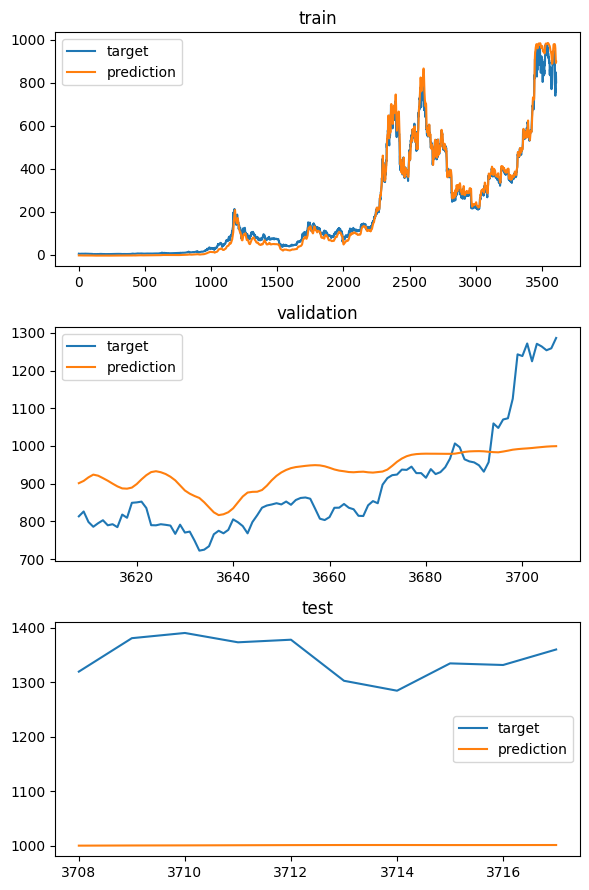

In [4]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# 경로를 BACKEND_AI에 맞춰 수정
BASE_PATH = str(Path().resolve().parent.parent.parent)  
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

# 데이터 파일을 따로 가져와서 사용했기에 import 수정
from f_arg_parser import get_parser
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

### 문제1, _01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

In [28]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
import sys
from pathlib import Path

wandb.login()

# BackEnd AI에 맞춰 경로 수정
BASE_PATH = str(Path().resolve().parent.parent.parent)  
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 파이썬 데이터를 가져와서 사용했기 때문에 import 파일 수정
from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser

def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config={
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': 0.0 # 이유는 모르겠으나 그대로 사용할 떄 오류 발생해서 직접 데이터 넣어줬음
    }
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model, log="all", log_freq=100)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0) # 위와 동일

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  sys.argv = ['']
  parser = get_parser()
  args = parser.parse_args()
  main(args)
  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69255, T_accuracy: 52.9629 | V_loss: 0.69243, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69001, T_accuracy: 53.2747 | V_loss: 0.69427, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69033, T_accuracy: 53.1897 | V_loss: 0.69353, V_accuracy: 46.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69054, T_accuracy: 53.1046 | V_loss: 0.69366, V_accuracy: 45.3333 | Early stopping counter: 3 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epoch 120] T_loss: 0.690

[Epoch 1440] T_loss: 0.54864, T_accuracy: 64.5875 | V_loss: 2.32650, V_accuracy: 53.3333 | Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:01:45, T_speed: 13.714
Final training time: 00:01:45


### 문제 1, _01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

In [29]:
import torch
import os
from pathlib import Path
from datetime import datetime
import sys
import wandb

# BackEnd AI에 맞춰서 경로 수정
BASE_PATH = str(Path().resolve().parent.parent.parent) 
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

# 파이썬 파일을 가져왔기 떄문에 import 경로 수정
from f_arg_parser import get_parser

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)


MODEL FILE: /home/work/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 56.667%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   0.00
10:   1.00 <-->   0.00
11:   1.00 <-->   1.00
12:   0.00 <-->   0.00
13:   1.00 <-->   1.00
14:   1.00 <-->   0.00
15:   1.00 <-->   1.00
16:   0.00 <-->   1.00
17:   1.00 <-->   0.00
18:   1.00 <-->   0.00
19:   0.00 <-->   1.00
20:   1.00 <-->   1.00
21:   0.00 <-->   1.00
22:   1.00 <-->   0.00
23:   0.00 <-->   0.00
24:   0.00 <-->   1.00
25:   1.00 <-->   1.00
26:   0.00 <-->   0.00
27:   1.00 <-->   1.00
28:   0.00 <-->   1.00
29:   1.00 <-->   1.00


## 문제 2

### 문제 2, Regression

In [21]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
import sys
from pathlib import Path

# 경로 설정
BASE_PATH = str(Path().resolve().parent.parent.parent)
CURRENT_FILE_PATH = str(Path().resolve())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            
            # LSTM Layer는 3개, hidden size는 128개 사용
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True)
            
            # Fully Connected Layer 추가
            # 첫 번째 FC Layer
            self.fc1 = nn.Linear(in_features=128, out_features=64)
            # Dropdout을 추가, p는 0.3
            self.dropout = nn.Dropout(p=0.3)
            # 활성화 함수로는 ReLU 사용
            self.relu = nn.ReLU()
            # 출력 FC Layer
            self.fc2 = nn.Linear(in_features=64, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x) # LSTM 적용하기
            x = x[:, -1, :]  # 마지막 시점의 출력만 사용
            x = self.fc1(x) # FC Layer 1 적용
            x = self.dropout(x) # Dropout 적용
            x = self.relu(x) # ReLU 활성화
            x = self.fc2(x) # FC Layer 2 적용
            return x
    
    # 문제 2번의 입력은 5개
    my_model = MyModel(n_input=5, n_output=1)
    return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
 
  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config={
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        # 각 아래에서 weight_decay와 sequence_size, validation_size, test_size를 추가적으로 설정하였음
        # 이는 주어진 default 값을 추가한 것
        'weight_decay': 0.01,
        'sequence_size': 21,  
        'validation_size': 150,
        'test_size': 30
    }
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model, log="all", log_freq=100)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  sys.argv = [''] 
  parser = get_parser()
  args = parser.parse_args()
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.01, 'sequence_size': 21, 'validation_size': 150, 'test_size': 30}
Training on device cuda:0.
[Epoch   1] T_loss: 9.53149, V_loss: 74.02052, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.018
[Epoch  30] T_loss: 8.37045, V_loss: 67.41312, V_loss decreased (74.02052 --> 67.41312). Saving model... | T_time: 00:00:01, T_speed: 0.050
[Epoch  60] T_loss: 1.46610, V_loss: 18.57397, V_loss decreased (67.41312 --> 18.57397). Saving model... | T_time: 00:00:03, T_speed: 0.238
[Epoch  90] T_loss: 0.58633, V_loss: 7.61239, V_loss decreased (18.57397 --> 7.61239). Saving model... | T_time: 00:00:04, T_speed: 0.104
[Epoch 120] T_loss: 0.39182, V_loss: 3.32153, V_loss

[Epoch 1860] T_loss: 0.14193, V_loss: 0.20192, V_loss decreased (0.20296 --> 0.20192). Saving model... | T_time: 00:01:41, T_speed: 2.926
[Epoch 1890] T_loss: 0.14311, V_loss: 0.20710, Early stopping counter: 1 out of 30 | T_time: 00:01:43, T_speed: 6.977
[Epoch 1920] T_loss: 0.14972, V_loss: 0.20074, V_loss decreased (0.20192 --> 0.20074). Saving model... | T_time: 00:01:44, T_speed: 2.108
[Epoch 1950] T_loss: 0.12885, V_loss: 0.20391, Early stopping counter: 1 out of 30 | T_time: 00:01:46, T_speed: 3.624
[Epoch 1980] T_loss: 0.14539, V_loss: 0.24896, Early stopping counter: 2 out of 30 | T_time: 00:01:48, T_speed: 12.479
[Epoch 2010] T_loss: 0.14518, V_loss: 0.20227, Early stopping counter: 3 out of 30 | T_time: 00:01:49, T_speed: 2.594
[Epoch 2040] T_loss: 0.14218, V_loss: 0.20095, Early stopping counter: 4 out of 30 | T_time: 00:01:51, T_speed: 3.684
[Epoch 2070] T_loss: 0.14743, V_loss: 0.21236, Early stopping counter: 5 out of 30 | T_time: 00:01:53, T_speed: 76.548
[Epoch 2100] T

[Epoch 3870] T_loss: 0.12010, V_loss: 0.18550, V_loss decreased (0.18711 --> 0.18550). Saving model... | T_time: 00:03:31, T_speed: 15.109
[Epoch 3900] T_loss: 0.11652, V_loss: 0.18767, Early stopping counter: 1 out of 30 | T_time: 00:03:32, T_speed: 4.354
[Epoch 3930] T_loss: 0.12122, V_loss: 0.18649, Early stopping counter: 2 out of 30 | T_time: 00:03:34, T_speed: 7.729
[Epoch 3960] T_loss: 0.12184, V_loss: 0.18933, Early stopping counter: 3 out of 30 | T_time: 00:03:36, T_speed: 23.183
[Epoch 3990] T_loss: 0.11559, V_loss: 0.18785, Early stopping counter: 4 out of 30 | T_time: 00:03:37, T_speed: 5.011
[Epoch 4020] T_loss: 0.12226, V_loss: 0.18694, Early stopping counter: 5 out of 30 | T_time: 00:03:39, T_speed: 6.852
[Epoch 4050] T_loss: 0.11945, V_loss: 0.21860, Early stopping counter: 6 out of 30 | T_time: 00:03:41, T_speed: 18.316
[Epoch 4080] T_loss: 0.10423, V_loss: 0.19924, Early stopping counter: 7 out of 30 | T_time: 00:03:42, T_speed: 6.197
[Epoch 4110] T_loss: 0.12320, V_l

[Epoch 5910] T_loss: 0.10982, V_loss: 0.18316, Early stopping counter: 8 out of 30 | T_time: 00:05:22, T_speed: 13.287
[Epoch 5940] T_loss: 0.11002, V_loss: 0.18266, Early stopping counter: 9 out of 30 | T_time: 00:05:24, T_speed: 87.734
[Epoch 5970] T_loss: 0.10920, V_loss: 0.18064, Early stopping counter: 10 out of 30 | T_time: 00:05:25, T_speed: 8.291
[Epoch 6000] T_loss: 0.10393, V_loss: 0.18605, Early stopping counter: 11 out of 30 | T_time: 00:05:27, T_speed: 16.761
[Epoch 6030] T_loss: 0.10211, V_loss: 0.20787, Early stopping counter: 12 out of 30 | T_time: 00:05:28, T_speed: 6.214
[Epoch 6060] T_loss: 0.10051, V_loss: 0.19339, Early stopping counter: 13 out of 30 | T_time: 00:05:30, T_speed: 9.961
[Epoch 6090] T_loss: 0.10351, V_loss: 0.17837, V_loss decreased (0.17892 --> 0.17837). Saving model... | T_time: 00:05:32, T_speed: 28.977
[Epoch 6120] T_loss: 0.10964, V_loss: 0.18094, Early stopping counter: 1 out of 30 | T_time: 00:05:33, T_speed: 6.986
[Epoch 6150] T_loss: 0.10540

[Epoch 7950] T_loss: 0.09302, V_loss: 0.17707, Early stopping counter: 1 out of 30 | T_time: 00:07:13, T_speed: 30.891
[Epoch 7980] T_loss: 0.10796, V_loss: 0.17388, V_loss decreased (0.17406 --> 0.17388). Saving model... | T_time: 00:07:14, T_speed: 9.287
[Epoch 8010] T_loss: 0.11036, V_loss: 0.18586, Early stopping counter: 1 out of 30 | T_time: 00:07:16, T_speed: 16.357
[Epoch 8040] T_loss: 0.10047, V_loss: 0.17584, Early stopping counter: 2 out of 30 | T_time: 00:07:18, T_speed: 64.370
[Epoch 8070] T_loss: 0.10181, V_loss: 0.17362, V_loss decreased (0.17388 --> 0.17362). Saving model... | T_time: 00:07:19, T_speed: 10.676
[Epoch 8100] T_loss: 0.10659, V_loss: 0.18733, Early stopping counter: 1 out of 30 | T_time: 00:07:21, T_speed: 22.219
[Epoch 8130] T_loss: 0.09768, V_loss: 0.17344, V_loss decreased (0.17362 --> 0.17344). Saving model... | T_time: 00:07:22, T_speed: 8.335
[Epoch 8160] T_loss: 0.09594, V_loss: 0.18445, Early stopping counter: 1 out of 30 | T_time: 00:07:24, T_spee

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
Training loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▂▁▁▂▃▁▁▁▁▁▂▁▆▁▁▁▂▂▂█▄▂▂▂▂▂▃▂▂▂▂▃▅▂▄▂▂
Validation loss,█▄▄▅▄▃▃▂▄▄▂▂▂▄▂▂▂▂▁▄▃▁▂▂▁▁▂▁▁▁▂▁▂▁▂▁▁▃▁▁
Epoch,9720
Training loss,0.09286
Training speed (epochs/sec.),17.06877
Validation loss,0.17387


### 문제2, Regression Test

MODEL FILE: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,062.99 <--> 1,331.62 (Loss:        268.63)
 1: 1,052.04 <--> 1,373.29 (Loss:        321.25)
 2: 971.25 <--> 1,238.69 (Loss:        267.45)
 3: 932.07 <--> 1,059.85 (Loss:        127.78)
 4: 936.44 <--> 1,070.26 (Loss:        133.82)
 5: 1,063.28 <--> 1,284.38 (Loss:        221.10)
 6: 943.46 <--> 1,073.52 (Loss:        130.06)
 7: 1,061.11 <--> 1,302.60 (Loss:        241.49)
 8: 933.79 <--> 957.10 (Loss:         23.31)
 9: 952.08 <--> 1,125.35 (Loss:        173.27)
10: 1,004.93 <--> 1,271.21 (Loss:        266.29)
11: 1,043.39 <--> 1,380.87 (Loss:        337.48)
12: 932.10 <--> 1,047.88 (Loss:        115.78)
13: 1,039.47 <--> 1,319.45 (Loss:        279.97)
14: 1,047.34 <--> 1,390.43 (Loss:        343.10)
15: 1,035.26 <--> 1,286.65 (Loss:        251.39)
16: 960.81 <--> 1,243.20 (Loss:        282.39)
17: 994.23 <--> 1,224.73 (Loss:        230.49)
18: 935.27 <--> 931.83 (Loss:          3.43)
1

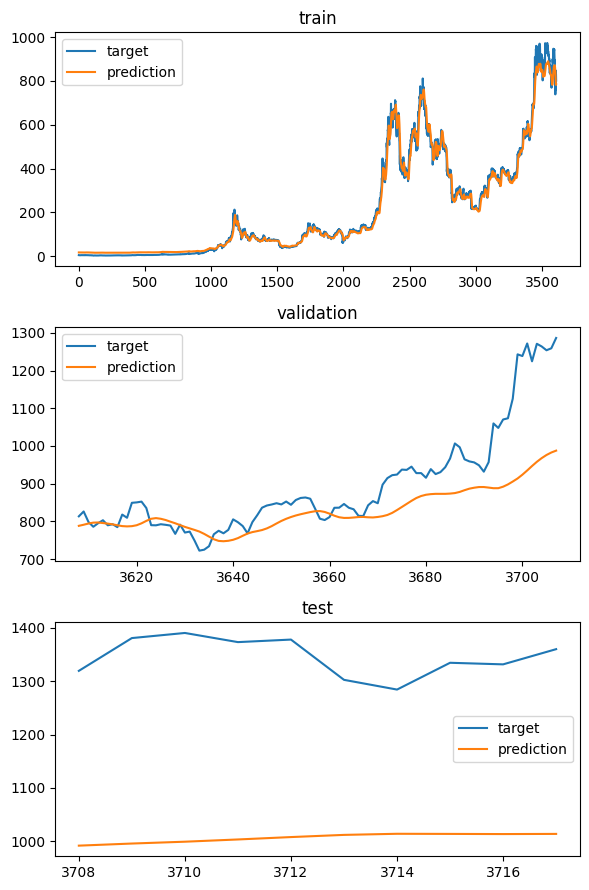

In [22]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# 경로를 BACKEND_AI에 맞춰 수정
BASE_PATH = str(Path().resolve().parent.parent.parent)  
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

# 데이터 파일을 따로 가져와서 사용했기에 import 수정
from f_arg_parser import get_parser
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    # 각 아래에서 weight_decay와 sequence_size, validation_size, test_size를 추가적으로 설정하였음
    # 이는 주어진 default 값을 추가한 것
    'weight_decay': 0.01, 
    'sequence_size': 21,   
    'validation_size': 150,  
    'test_size': 30         
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

### 문제 2, Classification

In [20]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
import sys
from pathlib import Path

wandb.login()

# 경로 설정
BASE_PATH = str(Path().resolve().parent.parent.parent)  # 상위 3단계 디렉토리
CURRENT_FILE_PATH = str(Path().resolve())  # 현재 파일의 경로
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser


def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            # LSTM Layer 설정, hidden_size = 256, dropout = 0.3으로 설정
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, dropout=0.3, num_layers=3, batch_first=True)

            # 첫 번째 FC Layer
            self.fc1 = nn.Linear(in_features=256, out_features=128)
            # Dropout, p = 0.3 설정
            self.dropout = nn.Dropout(p=0.3)
            # 활성화 함수 ReLU 사용
            self.relu = nn.ReLU()
            # 두 번째 FC Layer 
            self.fc2 = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x) # LSTM 적용
            x = x[:, -1, :]  # 마지막 시점의 출력만 사용
            x = self.fc1(x) # 첫 번째 FC Layer
            x = self.dropout(x) # Dropout 적용
            x = self.relu(x) # 활성화 함수 적용
            x = self.fc2(x) # 두 번째 FC Layer
            return x

    # 이진 분류라서 이번엔 출력값이 2개
    my_model = MyModel(n_input=5, n_output=2)
    return my_model


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config={
            'epochs': args.epochs,
            'batch_size': args.batch_size,
            'validation_intervals': args.validation_intervals,
            'learning_rate': args.learning_rate,
            'early_stop_patience': args.early_stop_patience,
            'early_stop_delta': args.early_stop_delta,
            'weight_decay': 0.0 # weight decay는 직접 설정했는데, args 직접 적용하면 오류나는 관계로
        }
    )
    print(args)
    print(wandb.config)

    # 데이터 로드
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 초기화 및 Wandb Watch
    model = get_model()
    model.to(device)
    wandb.watch(model, log="all", log_freq=100)

    # Optimizer 설정
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0)

    # 학습
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    sys.argv = ['']
    parser = get_parser()
    args = parser.parse_args()
    main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69124, T_accuracy: 52.9629 | V_loss: 0.69168, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69031, T_accuracy: 53.2180 | V_loss: 0.69423, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69089, T_accuracy: 52.9345 | V_loss: 0.69342, V_accuracy: 47.3333 | Early stopping counter: 2 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69017, T_accuracy: 53.1613 | V_loss: 0.69381, V_accuracy: 47.3333 | Early stopping counter: 3 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epo

Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▂▁▂▂▂▃▁▂▁▂▁▂▁▁▂▁▁▂▁▁▃▃▃▃▃▅▄▅█▆
Training loss,█▇█▇█▇█████████▇▇█▇▇▇▇▆▆▆▆▅▄▄▂▁
Training speed (epochs/sec.),▁███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▇▃▃▃▂▂▃▅▅▅▄▂▂▄▃▂▄▃▃▇█▃█▇▇▂▁▃▂▁▂
Validation loss,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▄▄▇█
Epoch,900
Training accuracy (%),54.4372
Training loss,0.67856
Training speed (epochs/sec.),12.85714
Validation accuracy (%),46


### 문제 2, Classification Test

In [30]:
import torch
import os
from pathlib import Path
from datetime import datetime
import sys
import wandb

# BackEnd AI에 맞춰서 경로 수정
BASE_PATH = str(Path().resolve().parent.parent.parent) 
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

# 파이썬 파일을 가져왔기 떄문에 import 경로 수정
from f_arg_parser import get_parser

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,                   
    'batch_size': args.batch_size,        
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,   
    'early_stop_patience': args.early_stop_patience,  
    'early_stop_delta': args.early_stop_delta, 
    'weight_decay': 0.0                        
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

MODEL FILE: /home/work/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 56.667%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   0.00 <-->   0.00
 3:   1.00 <-->   0.00
 4:   0.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   0.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   0.00 <-->   0.00
16:   0.00 <-->   1.00
17:   0.00 <-->   1.00
18:   1.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   1.00
21:   0.00 <-->   0.00
22:   1.00 <-->   0.00
23:   1.00 <-->   0.00
24:   1.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   1.00
28:   0.00 <-->   1.00
29:   0.00 <-->   0.00


## 문제 3

### 문제 3, Regression

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
import sys
from pathlib import Path


# 경로 설정
BASE_PATH = str(Path().resolve().parent.parent.parent)
CURRENT_FILE_PATH = str(Path().resolve())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
        get_cryptocurrency_data(
            sequence_size=sequence_size, 
            validation_size=validation_size, 
            test_size=test_size,
            target_column='Close', 
            y_normalizer=1.0e7, 
            is_regression=is_regression
        )

    # X_train.shape: (samples, sequence_size, 6) -> 피처 수가 6개 (`Next_Open` 포함)
    # 기존에 있던 CryptoCurrencyDataset에 Next_Open 추가
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader


def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            
            # 이 부분은 위에서 사용한 부분을 그대로 사용했음
            # LSTM Layer
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True)
            
            # Fully Connected Layer
            self.fc1 = nn.Linear(in_features=128, out_features=64)
            self.dropout = nn.Dropout(p=0.3) 
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(in_features=64, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 시점의 출력만 사용
            x = self.fc1(x)
            x = self.dropout(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    my_model = MyModel(n_input=6, n_output=1)  # n_input=6으로 수정
    return my_model

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
 
  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config={
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        # 각 아래에서 weight_decay와 sequence_size, validation_size, test_size를 추가적으로 설정하였음
        # 이는 주어진 default 값을 추가한 것
        'weight_decay': 0.01,
        'sequence_size': 21,  
        'validation_size': 150,
        'test_size': 30
    }
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model, log="all", log_freq=100)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  sys.argv = [''] 
  parser = get_parser()
  args = parser.parse_args()
  main(args)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 9.24948, V_loss: 72.66618, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.004
[Epoch  30] T_loss: 4.74253, V_loss: 45.00271, V_loss decreased (72.66618 --> 45.00271). Saving model... | T_time: 00:00:01, T_speed: 0.038
[Epoch  60] T_loss: 1.19330, V_loss: 15.72456, V_loss decreased (45.00271 --> 15.72456). Saving model... | T_time: 00:00:03, T_speed: 0.129
[Epoch  90] T_loss: 0.48502, V_loss: 6.94045, V_loss decreased (15.72456 --> 6.94045). Saving model... | T_time: 00:00:05, T_speed: 2.119
[Epoch 120] T_loss: 0.33578, V_loss: 2.50439, V_loss decreased (6.94045 --> 2.50439). Saving model... | T_time: 00:

[Epoch 1860] T_loss: 0.13114, V_loss: 0.06222, V_loss decreased (0.06259 --> 0.06222). Saving model... | T_time: 00:01:38, T_speed: 6.423
[Epoch 1890] T_loss: 0.11929, V_loss: 0.07028, Early stopping counter: 1 out of 30 | T_time: 00:01:39, T_speed: 2.225
[Epoch 1920] T_loss: 0.12812, V_loss: 0.05997, V_loss decreased (0.06222 --> 0.05997). Saving model... | T_time: 00:01:41, T_speed: 4.320
[Epoch 1950] T_loss: 0.12606, V_loss: 0.08682, Early stopping counter: 1 out of 30 | T_time: 00:01:43, T_speed: 70.172
[Epoch 1980] T_loss: 0.12928, V_loss: 0.06360, Early stopping counter: 2 out of 30 | T_time: 00:01:44, T_speed: 3.439
[Epoch 2010] T_loss: 0.13529, V_loss: 0.06653, Early stopping counter: 3 out of 30 | T_time: 00:01:46, T_speed: 13.506
[Epoch 2040] T_loss: 0.13081, V_loss: 0.06591, Early stopping counter: 4 out of 30 | T_time: 00:01:47, T_speed: 2.804
[Epoch 2070] T_loss: 0.12461, V_loss: 0.06962, Early stopping counter: 5 out of 30 | T_time: 00:01:49, T_speed: 6.406
[Epoch 2100] T

[Epoch 3900] T_loss: 0.11383, V_loss: 0.06563, Early stopping counter: 26 out of 30 | T_time: 00:03:24, T_speed: 10.007
[Epoch 3930] T_loss: 0.12217, V_loss: 0.07215, Early stopping counter: 27 out of 30 | T_time: 00:03:25, T_speed: 4.155
[Epoch 3960] T_loss: 0.10880, V_loss: 0.06491, Early stopping counter: 28 out of 30 | T_time: 00:03:27, T_speed: 7.306
[Epoch 3990] T_loss: 0.11380, V_loss: 0.08708, Early stopping counter: 29 out of 30 | T_time: 00:03:29, T_speed: 35.118
[Epoch 4020] T_loss: 0.11149, V_loss: 0.06963, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:03:30, T_speed: 5.854
Final training time: 00:03:30


Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▂▃█▃▁▂▁▄▁▂▃▂▂▁▁▂▃▃▂▁▆
Validation loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▃▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃▂▁▂
Epoch,4020
Training loss,0.11149
Training speed (epochs/sec.),5.85411
Validation loss,0.06963


### 문제 3, Regression Test

MODEL FILE: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,043.33 <--> 1,264.13 (Loss:        220.80)
 1: 969.84 <--> 1,070.26 (Loss:        100.42)
 2: 1,064.66 <--> 1,380.87 (Loss:        316.21)
 3: 1,077.52 <--> 1,302.60 (Loss:        225.09)
 4: 1,026.65 <--> 1,224.73 (Loss:        198.08)
 5: 1,018.80 <--> 1,272.01 (Loss:        253.21)
 6: 1,058.48 <--> 1,259.24 (Loss:        200.77)
 7: 985.33 <--> 1,073.52 (Loss:         88.19)
 8: 1,061.73 <--> 1,319.45 (Loss:        257.71)
 9: 925.19 <--> 957.10 (Loss:         31.91)
10: 1,053.11 <--> 1,254.02 (Loss:        200.90)
11: 949.35 <--> 959.09 (Loss:          9.75)
12: 1,066.07 <--> 1,390.43 (Loss:        324.36)
13: 947.21 <--> 1,047.88 (Loss:        100.66)
14: 999.84 <--> 1,125.35 (Loss:        125.51)
15: 1,018.90 <--> 1,238.69 (Loss:        219.79)
16: 1,033.82 <--> 1,271.21 (Loss:        237.39)
17: 946.40 <--> 948.70 (Loss:          2.30)
18: 935.60 <--> 931.83 (Loss:          3.76)
1

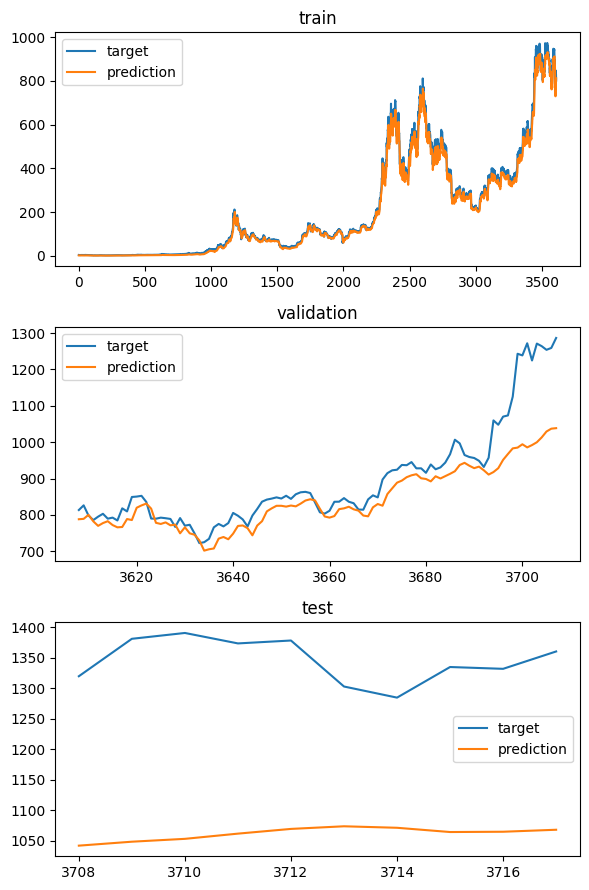

In [5]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

# 경로를 BACKEND_AI에 맞춰 수정
BASE_PATH = str(Path().resolve().parent.parent.parent)  
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

# 데이터 파일을 따로 가져와서 사용했기에 import 수정
from f_arg_parser import get_parser
from p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, CryptoCurrencyDataset

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    # 각 아래에서 weight_decay와 sequence_size, validation_size, test_size를 추가적으로 설정하였음
    # 이는 주어진 default 값을 추가한 것
    'weight_decay': 0.01, 
    'sequence_size': 21,   
    'validation_size': 150,  
    'test_size': 30         
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

### 문제 3, Classfication

In [18]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
import sys
from pathlib import Path

wandb.login()

# 경로 설정
BASE_PATH = str(Path().resolve().parent.parent.parent)  # 상위 3단계 디렉토리
CURRENT_FILE_PATH = str(Path().resolve())  # 현재 파일의 경로
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser


def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            
            # 이 부분은 위에서 사용한 부분을 그대로 사용하였음
            # LSTM Layer 개수: 3, dropout = 0.3으로 설정
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, dropout=0.3, num_layers=3, batch_first=True)

            # Fully Connected Layer
            self.fc1 = nn.Linear(in_features=256, out_features=128)
            # Dropout, p = 0.3 설정
            self.dropout = nn.Dropout(p=0.3)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 시점의 출력만 사용
            x = self.fc1(x)
            x = self.dropout(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    my_model = MyModel(n_input=6, n_output=2)
    return my_model


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config={
            'epochs': args.epochs,
            'batch_size': args.batch_size,
            'validation_intervals': args.validation_intervals,
            'learning_rate': args.learning_rate,
            'early_stop_patience': args.early_stop_patience,
            'early_stop_delta': args.early_stop_delta,
            'weight_decay': 0.0 # 이 값을 추가하면 값이 잘 나오지 않은 듯
        }
    )
    print(args)
    print(wandb.config)

    # 데이터 로드
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 초기화 및 Wandb Watch
    model = get_model()
    model.to(device)
    wandb.watch(model, log="all", log_freq=100)

    # Optimizer 설정
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0)

    # 학습
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    sys.argv = ['']
    parser = get_parser()
    args = parser.parse_args()
    main(args)

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.3}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69220, T_accuracy: 52.9912 | V_loss: 0.69214, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69062, T_accuracy: 53.5583 | V_loss: 0.69439, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69095, T_accuracy: 53.0479 | V_loss: 0.69365, V_accuracy: 47.3333 | Early stopping counter: 2 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69068, T_accuracy: 53.2180 | V_loss: 0.69348, V_accuracy: 47.3333 | Early stopping counter: 3 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epo

[Epoch 1440] T_loss: 0.55917, T_accuracy: 64.5308 | V_loss: 1.48628, V_accuracy: 56.0000 | Early stopping counter: 24 out of 30 | T_time: 00:01:51, T_speed: 12.973
[Epoch 1470] T_loss: 0.55587, T_accuracy: 64.3890 | V_loss: 1.49425, V_accuracy: 53.3333 | Early stopping counter: 25 out of 30 | T_time: 00:01:53, T_speed: 13.009
[Epoch 1500] T_loss: 0.55022, T_accuracy: 64.8426 | V_loss: 1.65822, V_accuracy: 53.3333 | Early stopping counter: 26 out of 30 | T_time: 00:01:55, T_speed: 13.043
[Epoch 1530] T_loss: 0.54099, T_accuracy: 65.8633 | V_loss: 1.71344, V_accuracy: 52.6667 | Early stopping counter: 27 out of 30 | T_time: 00:01:58, T_speed: 12.966
[Epoch 1560] T_loss: 0.54384, T_accuracy: 64.7859 | V_loss: 1.67772, V_accuracy: 53.3333 | Early stopping counter: 28 out of 30 | T_time: 00:02:00, T_speed: 13.000
[Epoch 1590] T_loss: 0.53821, T_accuracy: 65.6365 | V_loss: 1.81551, V_accuracy: 52.0000 | Early stopping counter: 29 out of 30 | T_time: 00:02:02, T_speed: 13.033
[Epoch 1620] T_l

### 문제 3, Classfication Test

In [19]:
import torch
import os
from pathlib import Path
from datetime import datetime
import sys
import wandb

# BackEnd AI에 맞춰서 경로 수정
BASE_PATH = str(Path().resolve().parent.parent.parent) 
CURRENT_FILE_PATH = str(Path().resolve()) 
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

# 파이썬 파일을 가져왔기 떄문에 import 경로 수정
from f_arg_parser import get_parser

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,                     # 학습 epoch 수
    'batch_size': args.batch_size,             # 배치 크기
    'validation_intervals': args.validation_intervals, # 검증 간격 (epochs 단위)
    'learning_rate': args.learning_rate,       # 학습률
    'early_stop_patience': args.early_stop_patience,   # Early stopping patience
    'early_stop_delta': args.early_stop_delta, # Early stopping delta
    'weight_decay': 0.3                        # Weight decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

MODEL FILE: /home/work/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 60.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   0.00 <-->   0.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   0.00 <-->   1.00
10:   1.00 <-->   0.00
11:   0.00 <-->   0.00
12:   0.00 <-->   1.00
13:   1.00 <-->   1.00
14:   1.00 <-->   1.00
15:   1.00 <-->   1.00
16:   0.00 <-->   1.00
17:   0.00 <-->   0.00
18:   0.00 <-->   0.00
19:   0.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   0.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   0.00 <-->   0.00
27:   1.00 <-->   0.00
28:   0.00 <-->   1.00
29:   0.00 <-->   1.00


### Regression 성능 비교
Next_Open을 추가하기 전엔 Validation_Loss의 값이 0.172이 최대였고, Accuracy 면에서도 50퍼 주변을 맴돌고, Test 데이터에서 Target과 Prediction 간 큰 차이가 존재했음.
Next_Opne을 추가한 이후로는 Validation_Loss가 0.065까지 줄어들어 눈에 띄게 감소한 면을 보여줬고, 이후에도 안정적인 감소 추세를 보였음. 이로 더 많은 정보를 학습해 Target을 더 잘 추적했음을 나타냄.
추가적으로 Training Accuracy는 60%도 넘기며, Validation Accuracy는 65%까지 올라가며 많은 개선을 보여주며, 테스트에서도 Target과 Prediction의 차이가 많이 줄었으며 이를 통해 Next_Open의 추가는 학습에 많은 도움을 줬음을 볼 수 있음.

### Classification 성능 비교
Classification에서는 Next_Open 추가 전 Training Loss가 0.69 - 0.67의 값, Validation Loss는 0.69 - 0.70의 값을 가지며, 전반적으로 큰 변화가 없었다. 이 과정에서 Test Accuracy가 56.667%임을 보였는데, 전반적으로 Validation과 비슷한 수준을 보였다.
Next_Open 추가 이후 Training Loss는 0.67 - 0.54까지 줄며 안정적인 학습을 진행했지만, Validation Loss는 0.76 - 1.68까지의 큰 값을 보이며 과적합 가능성을 보였다. Test Accuracy는 60%로 증가하며 3.33%의 성능 향상을 보이며, Training Accuracy와 Validation Accuracy도 전반적으로 증가한 모습을 보였다. 미미한 결과지만, Next_Open 추가로 Target과 Prediction의 일치율이 전반적인 증가를 보였음을 알 수 있음.

### 기술적 고찰 및 고찰
이번 과제를 통해서 느낀점은, 데이터는 많으면 많을수록 좋다는 점이다. 이를 느낀 구간은 Next_Open의 추가였는데, 이를 추가하니 전반적인 훈련, 검증, 테스트 과정에서의 성능 향상을 볼 수 있었다. 데이터의 양과 질이 이런 모델 성능에 큰 영향을 미칠 수 있다는 걸 보여줬지만, 문제점으로는 Classification에서는 과적합 문제가 생겼다는 점이어서 이후 추가적인 조치를 통해 이를 조정할 수 있지 않을까라는 생각이 들었다.
추가적으로 하이퍼파라미터의 조정은 모델 성능에 생각보다 큰 영향을 준다는 점이다. 이를 하나씩 수정하면서 확인하는 것은 좋았지만, 확실한 점은 하나하나 수정하면서 성능을 확인하는 부분에서 시간이 꽤 많이 소요되었다는 점에서는 딥러닝이 엄청난 시간 싸움임을 알 수 있었고, 시작부터 데이터 전처리 과정을 잘 생각해서 좋은 데이터를 사용하는 점이 몹시 중요할 것이라는 생각이 들었다.

### 숙제 후기
이번 과제를 진행하면서 오류를 너무 많이 마주쳐서, 하나하나 수정하면서 진행하느라 시간이 너무 오래걸렸다. 근데 직접적으로 비트코인 관련해서 직접 작업을 해봤는데, 테스트 결과가 왜 10% 정도만 오차가 나도 떼돈을 벌 것이라는 점은 잘 알았다. 이 비트코인 시장은 예측불가해서, 이미 되어있는 값을 사용해도 이렇게 큰 오차가 나는데, 이를 정밀하게 하나하나 수정해가면서 예측한다는게 사실상 가능한 문제인가 좀 궁금했다. 추가적으로 GPU 없으면 작업을 어떻게 하는지 궁금해졌다. 처음에 돌릴 때에는 잘 돌아가나 로컬에서 돌려봤는데, 이 과정에서 꽤 시간이 많이 걸리는 것을 확인했다.
하나하나 테스트 하면서 Wandb 오류나 하이퍼파라미터 튜닝이나 Dataset 수정 등 힘들었지만, 과제를 마치긴 해서 다행이라는 생각이 든다.